In [1]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
from tqdm.auto import trange
import itertools as it
import h5py
from copy import deepcopy

import numpy as np
import cvxpy as cp
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch_geometric.utils import dense_to_sparse

from sca import *
from utils import *
from models_uf import *


def anyvals(string, anyval):
    substrings = string.split('_')
    for si, substr in enumerate(substrings):
        if any(substr.startswith(aval) for aval in anyval):
            substrings[si] = substr.split('+')[0]+'*'
    return '_'.join(substrings)


from copy import deepcopy
import gc 



"""
classical SCA
"""
def classical_SCA(X, init='last', **kwargs):
    
    kwargs['SolverMaxIter'] = kwargs['SolverMaxIter'] if 'SolverMaxIter' in kwargs else 100
    kwargs['MaxIter'] = kwargs['MaxIter'] if 'MaxIter' in kwargs else 100
    kwargs['parm_alpha'] = kwargs['parm_alpha'] if 'parm_alpha' in kwargs else 0.01
    kwargs['RelTolFun'] = kwargs['RelTolFun'] if 'RelTolFun' in kwargs else 1e-12
    kwargs['RelTolVal'] = kwargs['RelTolVal'] if 'RelTolVal' in kwargs else 1e-12
    kwargs['InnerOpt'] = kwargs['InnerOpt'] if 'InnerOpt' in kwargs else 'sgd'
    
    n, d = X.shape
    nue = np.floor(d**.5).astype(int)
#     print(d, nue)
    assert nue**2+nue+1 == d

    xx = None
    gc.collect()
    xx = deepcopy(X)

    p0_valid = xx[:, :nue].numpy()
    hs_valid = xx[:, nue:-1].view(-1, nue, nue).numpy()
    pmax_valid = xx[:, -1].numpy()

    eeval = []
    for ni in trange(n):
        if (not ni or pmax_valid[ni-1] > pmax_valid[ni]) or init!='last':
            p0 = p0_valid[ni]
        else:
            p0 = P[-1]
        p = pmax_valid[ni]
        h = hs_valid[ni]/p

        O, P = SCA(h, mu = mu, Pc = Pc, Pmax = p, pt = p0, **kwargs)
        if np.isnan(O[-1]):
            P[-1] = p0_valid[ni]
            O[-1] = f_wsee(P[-1], h, mu, Pc)

        if np.isnan(O[-1]):
            raise

        eeval.append(O[-1])
    #     print(O[-1], P[-1])
    return eeval

## load data

In [2]:
#--- data---

num_ue = 4
mu = 4
Pc = 1

device = torch.device('cpu')


# train data
dfn3 = '../../data/results_hataUrban_noSF.h5'
X_tr, y_tr = [],[]
with h5py.File(dfn3, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    assert num_ue==Hs.shape[1]

    for hidx in trange(Hs.shape[0]):
        edge_index_tr, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
        x1 = (h.reshape((-1,1))*Plin).T # -->(h1p1, h2p1, h3p1, ...)
        X_tr.append(np.hstack((x1, Plin.reshape(-1,1))))
        y_tr.append(xopt[hidx,...] )                   

y_tr = np.concatenate((y_tr))
X_tr = np.concatenate((X_tr))
y_tr = y_tr[~np.any(np.isnan(X_tr),-1)]     
X_tr = X_tr[~np.any(np.isnan(X_tr),-1)]


# validation data
dfn4 = '../../data/results_hataUrban.h5'
X_va, y_va = [],[]
with h5py.File(dfn4, "r") as handle:
    Hs = handle['input']["channel_to_noise_matched"]
    Plin = 10**(np.asarray(handle['input']['PdB'][...], dtype=np.float)/10)
    xopt = handle['xopt']
    
    for hidx in trange(Hs.shape[0]):
        edge_index_va, h = dense_to_sparse(torch.from_numpy(Hs[hidx].astype(float)))
        x1 = (h.reshape((-1,1))*Plin).T # -->(h1p1, h2p1, h3p1, ...)
        X_va.append(np.hstack((x1, Plin.reshape(-1,1))))
        y_va.append(xopt[hidx,...] )

y_va = np.concatenate((y_va))
X_va = np.concatenate((X_va))
y_va = y_va[~np.any(np.isnan(X_va),-1)]     
X_va = X_va[~np.any(np.isnan(X_va),-1)]


# dfn4 = '../../data/dset%d.h5'%num_ue
# with h5py.File(dfn4, "r") as handle:
#     X_va = handle['validation']['input'][...]
#     y_va = handle['validation']['xopt'][...]

        
#--- (end)---

        
# to toech tensor
y_tr = torch.from_numpy(y_tr).float().to(device)
y_va = torch.from_numpy(y_va).float().to(device)

print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)



(51000, 17) torch.Size([51000, 4])
(51000, 17) torch.Size([51000, 4])


(array([9.8677e+04, 3.3392e+04, 3.6991e+04, 2.0696e+04, 9.4000e+03,
        3.3840e+03, 1.0410e+03, 3.2400e+02, 5.7000e+01, 3.8000e+01]),
 array([0.        , 0.01648412, 0.03296825, 0.04945238, 0.0659365 ,
        0.08242062, 0.09890475, 0.11538888, 0.131873  , 0.14835712,
        0.16484125], dtype=float32),
 <BarContainer object of 10 artists>)

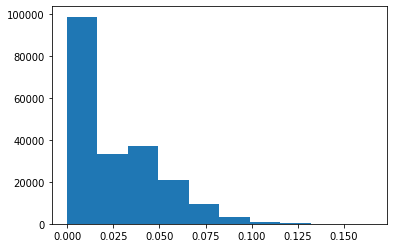

In [3]:
plt.hist(y_tr.numpy().flatten())

## unfolded sca pipeline

In [17]:

from sklearn.model_selection import StratifiedKFold

in_size = num_ue**2 + num_ue + 1
out_size = num_ue

h_sizes = [128, 64, 32, 32, 32, 16, 8]
activs = ['elu', 'relu', 'elu', 'relu', 'elu', 'relu',  'elu']

k_fold = 2
bs = 256
num_l = 3 # 1 2 3
nepochs = 100
learning_rate = 0.1

init = 'full'
rseed= 42
loss_which= ['mse','wsee']
architecture = USCA_MLP # USCA_MLP
inner_optim='learned-mlp'


skf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=rseed)

tr_loss, va_loss, te_loss = {},{},{}
tr_wsee, va_wsee, te_wsee = {},{},{}
# tr_wsee_sca, va_wsee_sca, te_wsee_sca = {},{},{}
tr_wsee_opt, va_wsee_opt, te_wsee_opt = {},{},{}

# add initial pt (max)
X_tr_ = torch.from_numpy(np.hstack((init_p(X_tr[:,-1], num_ue, method=init), X_tr))).float().to(device)
X_va_ = torch.from_numpy(np.hstack((init_p(X_va[:,-1], num_ue, method=init), X_va))).float().to(device)

for k, (train_index, valid_index) in enumerate(skf.split(X_tr, np.asarray([True]*y_tr.shape[0]))):
    # k fold cross validation
    
    X_train, y_train = X_tr_[train_index], y_tr[train_index]
    X_valid, y_valid = X_tr_[valid_index], y_tr[valid_index]
    X_test, y_test   = X_va_[valid_index], y_va[valid_index]
    
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    
    tr_wsee_opt[k] = f_wsee_torch(y_train, X_train, mu, Pc, 'mean').item()
    va_wsee_opt[k] = f_wsee_torch(y_valid, X_valid, mu, Pc, 'mean').item()
    te_wsee_opt[k] = f_wsee_torch(y_test, X_test, mu, Pc, 'mean').item()
    
#     tr_wsee_sca[k] = np.nanmean(classical_SCA( X_train , SolverMaxIter=7, MaxIter=3))
#     va_wsee_sca[k] = np.nanmean(classical_SCA( X_valid , SolverMaxIter=7, MaxIter=3))
#     te_wsee_sca[k] = np.nanmean(classical_SCA( X_test , SolverMaxIter=7, MaxIter=3))

torch.Size([25500, 21]) torch.Size([25500, 21]) torch.Size([25500, 4]) torch.Size([25500, 4])
torch.Size([25500, 21]) torch.Size([25500, 21]) torch.Size([25500, 4]) torch.Size([25500, 4])


In [13]:
tr_wsee_sca, va_wsee_sca, te_wsee_sca

({0: 7.7692885, 1: 7.7188053},
 {0: 7.7188053, 1: 7.7692885},
 {0: 8.957593, 1: 8.94186})

In [19]:
import json
from glob import glob
list_to_save = ['tr_loss', 'va_loss', 'te_loss', 'tr_wsee', 'va_wsee', 'te_wsee']

mod_archit = [USCA_MLP]#, USCA_MLP_R]
loss_which= []#['mse+wsee' ]#['mse','wsee']

tr_loss, va_loss, te_loss = {},{},{}
tr_wsee, va_wsee, te_wsee = {},{},{}

for ma in mod_archit:

    for lw in loss_which:
        key = ma.__name__.replace('_MLP','').replace('_R','r')+'|'+lw
        
        mstr = ma.__name__.replace('_','.')+'+'+inner_optim.replace('-','.')
        to_loadf='%s_kf+%d_bs+%d_nl+%d_lr+%2e_pinit+%s_loss+%s_rseed+%d'%(
            mstr, k_fold, bs, num_l, learning_rate, init, lw, rseed)
        to_loadf = anyvals(to_loadf, ['lr'])
        
        to_load = glob("./results/%s.json"%to_loadf)
        if not len(to_load):
            continue
        to_load = to_load[-1]
        print(to_load)

        with open(to_load, 'r') as fp:
            evals = json.load(fp)
            tr_loss[key] = evals['tr_loss']
            va_loss[key] = evals['va_loss']
            te_loss[key] = evals['te_loss']

            tr_wsee[key] = evals['tr_wsee']
            va_wsee[key] = evals['va_wsee']
            te_wsee[key] = evals['te_wsee']

tr_wsee.keys()

dict_keys([])

In [20]:
keys_extra = ['USCA|mse+wsee(14952)', 'MLP|mse+wsee(14864)','USCA|mse+wsee(95784)','MLP|mse+wsee(95264)']
# toload_extra = ['./results/MLP+vanilla_kf+2_bs+256_nl+0_lr+1.000000e-02_pinit+none_loss+mse_rseed+42/log.2fcv.json',
#                 './results/MLP+vanilla_kf+2_bs+256_nl+0_lr+1.000000e-02_pinit+none_loss+wsee_rseed+42/log.2fcv.json',
#                 './results/MLP+vanilla_kf+2_bs+256_nl+0_lr+1.000000e-02_pinit+none_loss+mse+wsee_rseed+42/log.2fcv.json']

toload_extra = ['./results/small_USCA.MLP+learned.mlp_kf+2_bs+512_nl+3_lr+1.000000e-03_pinit+rand_loss+mse+wsee_rseed+42/log.2fcv.json',
               './results/small_basic.mlp+vanilla_kf+2_bs+512_nl+0_lr+1.000000e-03_pinit+none_loss+mse+wsee_rseed+42/log.2fcv.json',
               './results/large_USCA.MLP+learned.mlp_kf+2_bs+512_nl+3_lr+1.000000e-03_pinit+rand_loss+mse+wsee_rseed+42/log.2fcv.json',
               './results/basic.mlp+vanilla_kf+2_bs+512_nl+0_lr+1.000000e-03_pinit+none_loss+mse+wsee_rseed+42/log.2fcv.json']


for kx, tl in zip(keys_extra, toload_extra):
    with open(tl, 'r') as fp:
        evals = json.load(fp)
        tr_loss[kx] = evals['tr_loss']
        va_loss[kx] = evals['va_loss']
        te_loss[kx] = evals['te_loss']

        tr_wsee[kx] = evals['tr_wsee']
        va_wsee[kx] = evals['va_wsee']
        te_wsee[kx] = evals['te_wsee']


# classical SCA

In [12]:
va_wsee_sca

{0: 7.7188053, 1: 7.7692885}

Text(100, 7.7, '                                   ')

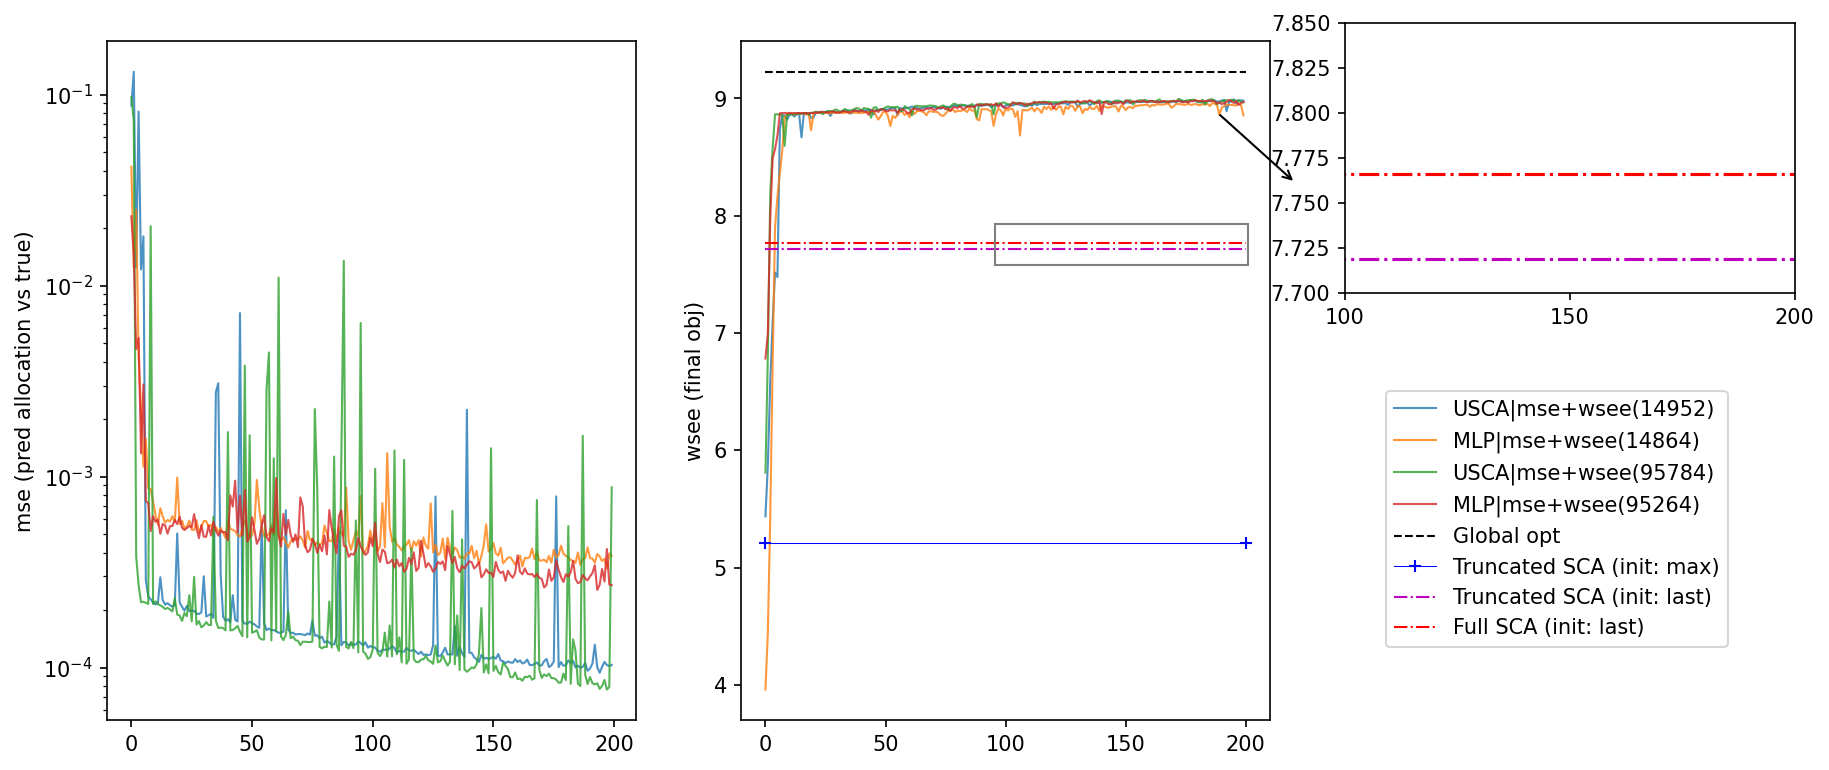

In [22]:
kk = '0'

plt.figure(figsize=(10,6), dpi=150)
plt.subplot(121)
for k, v in va_loss.items():
    mse = np.array(v[kk])
    if len(mse)<150: mse = np.interp(range(200), range(len(mse)), mse)
    plt.plot(mse, label=k, linewidth=1, alpha=.8)
    
plt.yscale('log')
# plt.legend()
plt.ylabel('mse (pred allocation vs true)')

main_axes = plt.subplot(122)
sub_axes = plt.axes([.95, .6, .3, .3]) # location for the zoomed portion 

for k, v in te_wsee.items():
    wsee = np.array(v[kk])
#     if np.all(wsee<2): wsee*=4
#     if len(wsee)<150: wsee = np.interp(range(200), range(len(wsee)), wsee)
    main_axes.plot(wsee, label=k, linewidth=1, alpha=.8)
    sub_axes.plot(wsee) 
    
xs = [0, len(wsee)]
main_axes.plot(xs, [te_wsee_opt[int(kk)]]*2, 'k--', label='Global opt', linewidth=1)

main_axes.plot(xs, [5.2116127]*2, 'b+-', label='Truncated SCA (init: max)', linewidth=.5)
main_axes.plot(xs, [va_wsee_sca[int(kk)]]*2, 'm-.', label='Truncated SCA (init: last)', linewidth=1)
main_axes.plot(xs, [7.766158]*2, 'r-.', label='Full SCA (init: last)', linewidth=1)

# main_axes.set_xscale('log')
main_axes.set_ylabel('wsee (final obj)')
main_axes.legend(bbox_to_anchor=(1.2, .5), loc='upper left')

# zoom in, box and arrow
sub_axes.plot(xs, [te_wsee_opt[int(kk)]]*2, 'k--', label=None)
sub_axes.plot(xs, [5.2116127]*2, 'b+-', label=None)
sub_axes.plot(xs, [va_wsee_sca[int(kk)]]*2, 'm-.', label=None)
sub_axes.plot(xs, [7.766158]*2, 'r-.', label=None)

sub_axes.set_ylim([7.7, 7.85])
sub_axes.set_xlim([100,200])
sub_axes.set_xticks([100,150,200])

main_axes.annotate('', xy=(1.05,.79), xycoords='axes fraction', xytext=(.9, .895), arrowprops=dict(arrowstyle="->"))
main_axes.text(100, 7.7, ' '*35, color='k', bbox=dict(facecolor='none', edgecolor='gray', pad=5.0))

In [150]:
torch.cuda.empty_cache()